# Import packages and data {-}

In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import examplematrices
import chladni_show 

In [2]:
#import data
Kmat = np.load('Chladni-Kmat.npy')
basis = np.load('chladni_basis.npy')

# Question a {-}
Below is implemented a function that returns the centers and radii of the Gershgorin disks of an input matrix.

In [3]:
def gershgorin(A):
    centers = []
    radii = []
    
    for i in range(len(A)):
        centers.append(A[i,i])
        
        radius = 0
        for j in range(len(A)):
            if j != i:
                radius += abs(A[i,j])
        radii.append(radius)
    
    return centers, radii

Below the centers and radii of the Gershgorin disks of matrix K are found using the above function. 

In [4]:
#compute centers and radii of K matrix
centers, radii = gershgorin(Kmat)
df = pd.DataFrame(np.array([centers,radii]).T, columns=['Centers', 'Radii'])
df

,Centers,Radii
0,129292.219206,42231.646726
1,103041.439420,56927.518940
2,64967.578727,31160.670887
3,43612.411909,18532.348737
4,36273.751516,7870.516137
5,37990.099373,17854.702613
6,24166.971120,15414.716667
7,11651.158690,2512.041395
8,13865.080461,5502.969527
9,5600.547665,1195.283294


# Question b {-}
Below is defined a function to calculate the Rayleigh quotient (approximate eigenvalue) from a matrix and an approximate eigenvector. 

In [5]:
#rayleigh quotient function
def rayleigh_qt(A,x):
    return (x.T@A@x)/(x.T@x)

Below a function is defined to return an eigenvector and the number of iterations used from an input matrix and inital vector using power iteration. The convergence criterion for the power iteration is when the Rayleigh residual is less than 1e-8. The reason for this convergence criterion is that a small Rayleigh residual means a good eigenvalue.  

In [6]:
#power iteration function
def power_iterate(A,x0):
    x = np.copy(x0)
    res = 1 #initialize Rayleigh residual
    k = 0 #initialize iteration index
    
    while res > 10**(-8):
        k += 1
        x = A@x #compute eigenvector approximation
        x = x/np.linalg.norm(x, ord=np.inf) #normalize 
        lambd = rayleigh_qt(A, x) #compute largest eigenvalue for eigenvector
        res = np.linalg.norm(A@x-lambd*x) #compute Rayleigh residual
        
    return x, k

Below is defined a function which combines the two above functions to compute the largest eigenvalue of a matrix along with the Rayleigh residual and the number of iterations used. 

In [7]:
#combined function to find largest eigenvalue
def power_iterate_test(A):
    x0 = np.random.rand(len(A)) #initialize random vector for power iteration
    x, k = power_iterate(A, x0) #get eigenvector and iterations 
    lambd = rayleigh_qt(A, x) #get largest eigenvalue
    res = np.linalg.norm(A@x-lambd*x) #compute Rayleigh residual
    
    return lambd, res, k

Below the function is tested on the example matrices.

In [8]:
#test on example matrices
A1 = examplematrices.A1
A2 = examplematrices.A2
A3 = examplematrices.A3
A4 = examplematrices.A4
A5 = examplematrices.A5
A6 = examplematrices.A6
As = [A1, A2, A3, A4, A5, A6]
A_str = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6']

ls = [power_iterate_test(A)[0] for A in As]
res = [power_iterate_test(A)[1] for A in As]
ks = [power_iterate_test(A)[2] for A in As]

df = pd.DataFrame(np.array([A_str, ls, res, ks]).T, columns=['Matrix', 'Eigenvalue', 'Rayleigh residual', 'k'])
df

,Matrix,Eigenvalue,Rayleigh residual,k
0,A1,4.0,9.93761383237449e-09,30
1,A2,4.0,5.602140135542387e-09,22
2,A3,12.298958391752736,3.749052958047478e-09,21
3,A4,16.11684397125344,1.7345960697348463e-09,8
4,A5,68.64208073778644,7.173074220080367e-10,8
5,A6,2.0,6.759690853462393e-09,26


Below the largest eigenvalue of the K matrix is found using the power iterate and Rayleigh quotients from above.

In [9]:
#find largest eigenvalue of K matrix
x0 = np.random.rand(len(Kmat)) #initialize random vector
x = power_iterate(Kmat, x0)[0] #get eigenvector
l = rayleigh_qt(Kmat,x) #get eigenvalue

print('The largest eigenvalue of the K matrix is '+str(l)+'.')

The largest eigenvalue of the K matrix is 151362.6664880076.


Below the eigenfunction and nodes are shown using the show_waves and show_nodes functions respectively. 

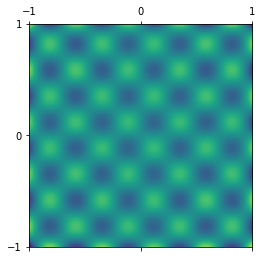

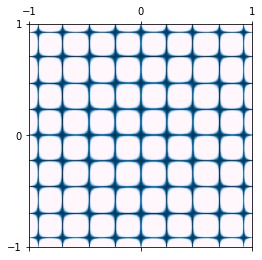

In [10]:
#show wave pattern
chladni_show.show_waves(x, basis)

#show sand pattern
chladni_show.show_nodes(x, basis)

# Question c {-}
Below the functions to perform LU factorization defined in Project 1 are copy pasted to be used for multiplication by the inverse matrix in the Rayleigh quotient iteration function. 

In [11]:
#import old functions

#LU factorization
def lu_factorize(M):
    n = np.shape(M)[0]
    L = np.identity(n)
    U = np.copy(M).astype('float64')
    
    for i in range(n): #loop over rows in input matrix
        k = U[i+1:,i]/U[i, i] #compute row multiple(s) to subtract by dividing element(s) by pivot
        L[i+1:, i] = k #insert multiple(s) to create lower triangular matrix
        U[i+1:] -= k[:, np.newaxis]*U[i] #subtract multiple(s) of rows to eliminate subdiagonals
        
    return L, U

#forward substitution
def forward_sub(L, b):
    n = np.shape(L)[0]
    y = np.zeros(n) #initialize solution vector as zeros
    
    y[0] = b[0]/L[0,0] #use first row of L to give first element of y
    for i in range(1,n):
        y[i] = (b[i]-np.dot(L[i,:i], y[:i]))/L[i,i] #perform forward substitution row-wise from top
    
    return y  

#back substitution
def back_sub(U, y):
    n = np.shape(U)[0]
    x = np.zeros(n) #initialize solution vector as zeros
    
    x[-1] = y[-1]/U[-1,-1] #use last row of U to give last element of x
    for i in range(n-2,-1,-1):
        x[i] = (y[i]-np.dot(U[i,i:], x[i:]))/U[i,i] #perform back substitution row-wise from bottom
    
    return x


#combined LU solve
def lu_solve(A, b):
    
    L, U = lu_factorize(A)
    y = forward_sub(L, b)
    x = back_sub(U, y)
    
    return x

Below a function is defined to perform Rayleigh quotient iteration from an input matrix, initial vector and approximate eigenvalue shift. The convergence criterion is once again set to when the Rayleigh residual is less than 1e-8. The reason to use the same convergence criterion as for the power iterate function is to be able to compare the number of iterations needed for convergence between the two functions.  

In [12]:
def rayleigh_iterate(A, x0, shift0):
    
    #initialize
    A = np.copy(A)
    x = np.copy(x0)
    shift = shift0
    res = 1
    
    #initial loop
    for i in range(10):
        x = lu_solve(A-shift*np.identity(len(A)),x)
        x = x/np.linalg.norm(x)
    
    #Rayleigh loop
    k = 0
    while res > 10**(-8):
        k += 1
        x = lu_solve(A-shift*np.identity(len(A)), x) #use LU solve to get eigenvector
        x = x/np.linalg.norm(x) #normalize eigenvector
        shift = rayleigh_qt(A, x) #compute largest eigenvalue for eigenvector
        res = np.linalg.norm(A@x-shift*x) #compute Rayleigh residual
        
    return x, k

Below is defined a function which combines the Rayleigh iteration function above with the Rayleigh quotient function to compute the nearest eigenvalue of a matrix along with the Rayleigh residual and the number of iterations used. 

In [13]:
#function to test Rayleigh quotient iteration
def rayleigh_test(A):
    x0 = np.ones(len(A)) #initialize vector for power iteration
    shift0 = np.random.randint(-50,51) #random initial eigenvalue between -50 and 50
    x, k = rayleigh_iterate(A, x0, shift0) #get eigenvector and iterations 
    lambd = rayleigh_qt(A, x) #get largest eigenvalue
    res = np.linalg.norm(A@x-lambd*x) #compute Rayleigh residual
    
    return lambd, res, k

Below the function is tested on the example matrices. 

Please note: since for each time the rayleigh_test function is run a new random initial eigenvalue (shift) between -50 and 50 is generated, the final eigenvalue computed might differ from round to round since the rayleigh_iterate function simply finds the eigenvector for the eigenvalue closest to the initial eigenvalue. 

In [14]:
#test on example matrices
A1 = examplematrices.A1
A2 = examplematrices.A2
A3 = examplematrices.A3
A4 = examplematrices.A4
A5 = examplematrices.A5
A6 = examplematrices.A6
As = [A1, A2, A3, A4, A5, A6]
A_str = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6']

ls = []
res = []
ks = []
for A in As:
    lambd, residual, ite = rayleigh_test(A)
    ls.append(lambd)
    res.append(residual)
    ks.append(ite)

df = pd.DataFrame(np.array([A_str, ls, res, ks]).T, columns=['Matrix', 'Eigenvalue', 'Rayleigh residual', 'k'])
df

,Matrix,Eigenvalue,Rayleigh residual,k
0,A1,4.0,0.0,1
1,A2,4.0,0.0,1
2,A3,-4.480573770335489,1.870328775507855e-13,4
3,A4,-1.1168439698311037,8.464048636913294e-11,3
4,A5,-3.642080737002404,7.915401605656394e-15,2
5,A6,2.0,1.5929240867215848e-09,4


# Question d {-}
Pure power iteration converges to the eigenvector for the largest eigenvalue. Applying the initial eigenvalue shift in the Rayleigh quotient iteration function allows for any eigenpair to be computed simply by changing the initial eigenvalue shift. 

Below the eigenvectors and eigenvalues of the K matrix are found using the Rayleigh quotient iteration function and the Gershgorin centers found in question a.

In [15]:
#find eigenpairs of K matrix
vals = []
vecs = []

for center in centers:
    center = np.round(center, decimals=5) #centers are rounded to 5 decimals to avoid singularity
    x0 = np.ones(len(Kmat)) #random initial vector
    vec = rayleigh_iterate(Kmat, x0, center)[0] #compute eigenvector
    val = rayleigh_qt(Kmat, vec) #compute eigenvalue
    vecs.append(vec) #append to list of eigenvectors
    vals.append(val) #append to list of eigenvalues
    
vecs = np.array(vecs)
vals = np.array(vals)

#sort eigenvalues and eigenvectors in order of ascending eigenvalues
index = vals.argsort()
vals = vals[index]
vecs = vecs[index]

Below the the eigenvalues found above are compared to the true values found via Numpy's linear algebra library. 

In [16]:
#find and sort true eigenvalues
true_vals, true_vecs = np.linalg.eig(Kmat) #find eigenpairs using Numpy
true_vecs = true_vecs.T #transpose eigenvectors to make each row a vector
index_true = true_vals.argsort()
true_vals = np.round(true_vals[index_true],5)
true_vecs = true_vecs[index_true]

#compare with computed eigenvalues
matches = 0
for i in range(len(vals)):
    if vals[i].round(5) == true_vals[i].round(5):
        matches += 1

print('The number of correct eigenvalues is '+str(matches)+'.')

The number of correct eigenvalues is 14.


The reason why one of the computed eigenvalues is a duplicate of another insted of being a unique eigenvalue is that two of the Gershgorin centers are closer to the same eigenvalue and thus both converge to that.  
Below all the unique eigenvalue are found by not only using the Rayleigh quotient iteration function on the Gershgorin centers but also on the values on the edge of the Gershgorin disks to get bounds on the eigenvalues. 

In [17]:
#find eigenpairs of K matrix using both centers and radii
vals = []
vecs = []

for center, radius in zip(centers, radii):
    center = np.round(center, decimals=5) #centers are rounded to 5 decimals to avoid singularity
    x0 = np.ones(len(Kmat)) #random initial vector
    
    vec = rayleigh_iterate(Kmat, x0, center)[0] #compute eigenvector
    val = rayleigh_qt(Kmat, vec) #compute eigenvalue
    vecs.append(vec) #append to list of eigenvectors
    vals.append(val) #append to list of eigenvalues
    
    vec = rayleigh_iterate(Kmat, x0, center+radius)[0] 
    val = rayleigh_qt(Kmat, vec) 
    vecs.append(vec) 
    vals.append(val) 
    
    vec = rayleigh_iterate(Kmat, x0, center-radius)[0] 
    val = rayleigh_qt(Kmat, vec) 
    vecs.append(vec) 
    vals.append(val) 
    
vals, index = np.unique(np.round(vals, 5), return_index=True) #round off eigenvalues and find unique values
vecs = np.array(vecs)
vecs = vecs[index] #only use unique eigenvectors corresponding to unique eigenvalues

Below the newly found eigenvalues are compared to the true values from Numpy. 

In [18]:
#compare with computed eigenvalues
matches = 0
for i in range(len(vals)):
    if vals[i] == true_vals[i]:
        matches += 1

print('The number of correct eigenvalues is '+str(matches)+'.')

The number of correct eigenvalues is 15.


Below the eigenfunction with the lowest eigenvalue is visualized to confirm its shape of a cross. 

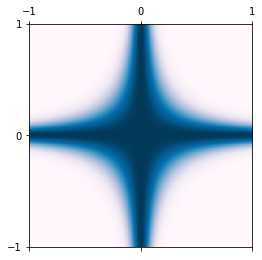

In [19]:
#show lowest eigenfunction
min_vec = vecs[np.argmin(vals)]
chladni_show.show_nodes(min_vec, basis)

Below the tranformation matrix T is constructed consisting of the eigenvectors of the K matrix in order of ascending eigenvalue. 

In [20]:
#contruct transformation matrix
Lambda = np.diag(vals) #construct lambda matrix of diagonal eigenvalues
T = vecs.T #construct T matrix
T_inv = np.linalg.inv(T) #construct inverse T matrix
K = T@Lambda@T_inv #test by constructing K matrix
np.allclose(K, Kmat)

True

Below the wavefunction for all eigenfunctions of the K matrix are visualized using the show_all_wavefunction_nodes function. 

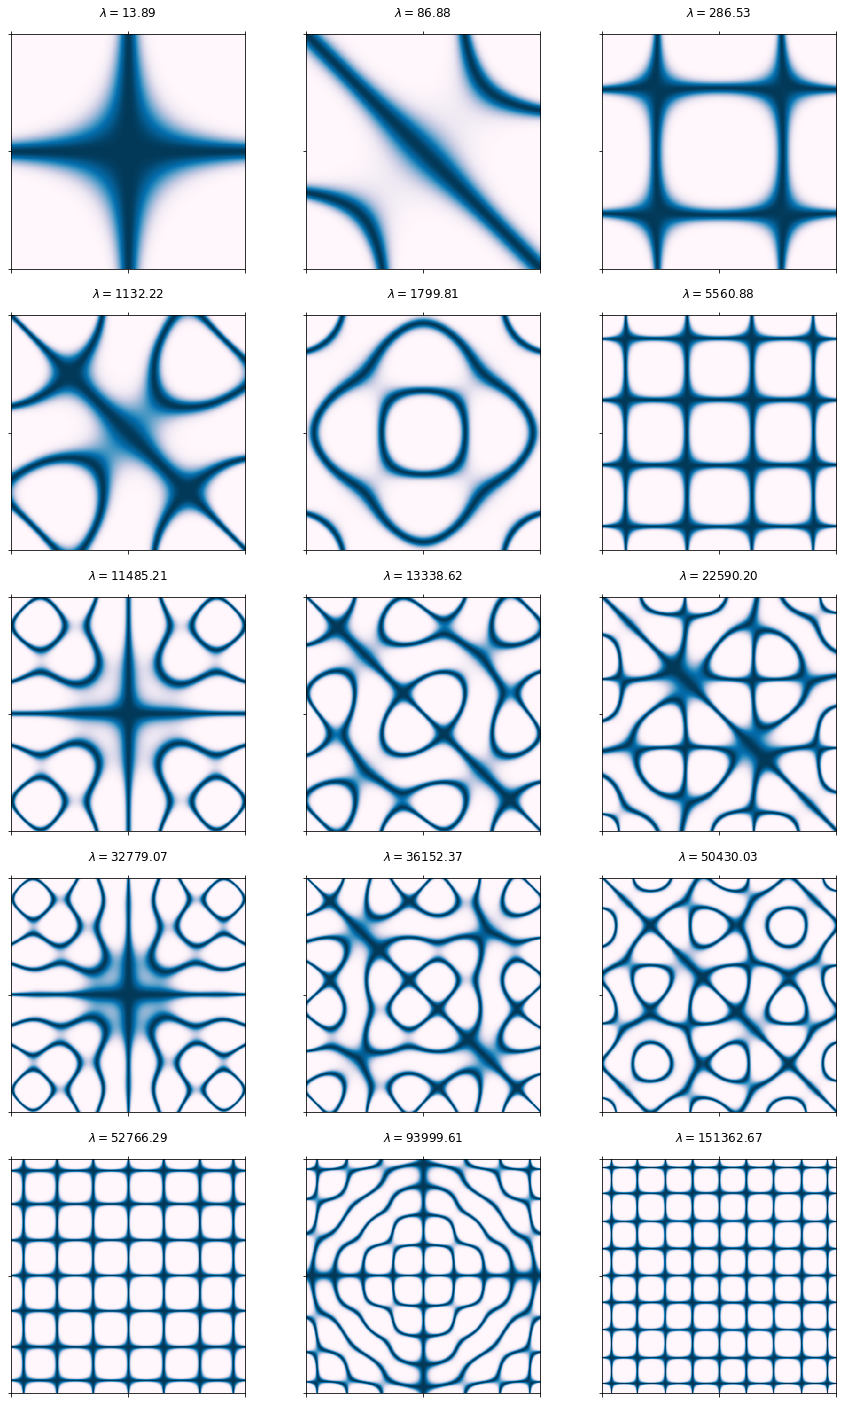

In [21]:
chladni_show.show_all_wavefunction_nodes(T,vals,basis)